In [1]:
import time
import random
import numpy as np
import pulp as plp
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib notebook

from gurobipy import *
import multiprocessing

def Model(weights, signed_matrix):

    objectivevalue=[]
    objs=[]
    solveTime=[]
    
    index=0 
    order=len(signed_matrix[index])

    ###############################################################################################
    opt_model = plp.LpProblem(name="Binary_Model",sense = plp.LpMinimize)

    x=[]
    for i in range(0,order):
        x.append(plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='x'+str(i)))
    z={}    
    for (i,j) in (weights[index]):
        z[(i,j)]=plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='z'+str(i)+','+str(j))
    ###############################################################################################
    OFV = 0
    for (i,j) in (weights[index]):
        OFV += z[(i,j)]

    opt_model.setObjective(OFV)

    for (i,j) in (weights[index]):
        opt_model.addConstraint( z[(i,j)] >= x[i] - ((weights[index])[(i,j)])*x[j] -\
                        (1-(weights[index])[(i,j)])/2)
        opt_model.addConstraint( z[(i,j)] >= -x[i] + ((weights[index])[(i,j)])*x[j] +\
                        (1-(weights[index])[(i,j)])/2)   

    ###############################################################################################
    
    start_time = time.time()
    status = opt_model.solve(solver = plp.getSolver('GUROBI_CMD'))#'COIN_CMD'))
    solveTime.append(time.time() - start_time) 

    ###############################################################################################

    varsdict = {}
    for v in opt_model.variables():
        varsdict[v.name] = v.varValue    
                    
    return float(opt_model.objective.value()), varsdict

def Prepare_Data(matrices):

    signed_matrices=[]
    unsigned_matrices=[]
    weights = []
    graphs=[]
    for signed_matrix in matrices:

        Graph=nx.from_numpy_matrix(signed_matrix)

        mapping=dict(zip(Graph.nodes(),range(len(Graph.nodes()))))
        Graph=nx.relabel_nodes(Graph,mapping) 

        graphs.append(Graph)

        signed_matrix = nx.to_numpy_matrix(Graph)
        unsigned_matrix = abs(signed_matrix)    

        weighted_edges=nx.get_edge_attributes(Graph, 'weight') 
        w={}
        for (u,v) in weighted_edges:
            if u<v:
                w[(u,v)] = weighted_edges[(u,v)]
            if u>v:
                w[(v,u)] = weighted_edges[(u,v)]

        signed_matrices.append(signed_matrix)
        unsigned_matrices.append(unsigned_matrix)
        weights.append(w)

    return graphs, weights, signed_matrices

def color_nodes(G,variables):
    
    d = {}
    for key, value in variables.items():
        if "x" in key:
            #print(key[1:],value)
            d[int(key[1:])]=value

    var = dict(sorted(d.items()))
    
    node_colors=[]
    for key,value in var.items():
        if value==1:
            node_colors.append("black")
        else:
            node_colors.append("silver")
            
    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        #print(node,color)
        attr[node]=color
        
    nx.set_node_attributes(G, attr, 'color')
    
    return G

def Add_Weights(H,k):
    
    N = len(H.edges())

    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(n+m)
    a[:m] = -1
    np.random.shuffle(a)
    
    dic={}
    for e,value in zip(H.edges(),a):
        dic[e] = value
    
    nx.set_edge_attributes(H, dic,'weight')
    
    return H

In [7]:
def create_data(n):
    
    k = 0.5
    
    #G = nx.triangular_lattice_graph(n,n)
    G = nx.grid_2d_graph(n,n)
    #G = nx.path_graph(n)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    G = Add_Weights(G,1.0)
    
    
    matrix = nx.to_numpy_matrix(G)
    g, weights, signed_matrix = Prepare_Data([matrix])

    fi,vr = Model(weights, signed_matrix)
    #frustrations.append(fi)
    G = color_nodes(G,vr)
    
    pos = nx.spring_layout(G, weight=None)
    nx.set_node_attributes(G,pos,'pos')
    

    return G

In [8]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            s+=1
    return s

def color_of_frustration(G):
    
    positive=0
    negative=0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            
            if G.nodes[n1]['color'] == G.nodes[n2]['color'] == "Black":
                negative +=1
            else:
                positive +=1
    return positive,negative

import random
import math
from random import choice
from random import sample

def simulated_annealing(G,target):
    """Peforms simulated annealing to find a solution"""
    initial_temp = 90
    final_temp = .1
    alpha = 0.01
    
    current_temp = initial_temp

    current_state = G
    solution = current_state

    while current_temp > final_temp:
        
        random_node = sample(current_state.nodes(),1)[0]
        H = change(current_state.copy(),random_node)
        
        new = calculate_delta(H)
        old = calculate_delta(current_state)
        
        cost_diff = get_cost(target,old) - get_cost(target,new)

        if get_cost(target,new) == 0:
            return H.copy()
        if get_cost(target,new) < get_cost(target,old):
            current_state = H.copy()
        else:
            if random.uniform(0, 1) < math.exp(-get_cost(target,new)/ current_temp):
                current_state = H.copy()
        current_temp -= alpha

    return current_state

def change(G,random_node):

    chosen_color = G.nodes[random_node]['color']
    if chosen_color == "Silver":
        G.nodes[random_node]['color'] = "Black"
    else:
        G.nodes[random_node]['color'] = "Silver"
    
    return G.copy()

def get_cost(target,new):

    return np.abs(target-new)
 
def calculate_delta(G):
    
    p,n = color_of_frustration(G)
    return int(np.sqrt((p-n)**2))

def Plot2D(G):

    pos =nx.get_node_attributes(G,'pos')
    node_colors=nx.get_node_attributes(G,'color')
    edge_colors=nx.get_edge_attributes(G,'edge_color')

    fig, ax = plt.subplots(figsize=(2,2))
    nx.draw(G,pos,node_size=50,edge_color="red",node_color=node_colors.values(),with_labels=False)

<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Testing

# KVINČING 2

In [76]:
Gs = []

for i in tqdm(range(100)):
    
    G0 = create_data(10)
    
    edge = len(G0.copy().edges())
    
    H = G0.copy()
    
    d_target = int(edge/2) 
    while (calculate_delta(H) != d_target):# and frustration_count(H) != 0):
        
        H = simulated_annealing(G0.copy(),target=d_target)
        
    print(frustration_count(H),calculate_delta(H),end=" ")
        
    Gs.append(H.copy())

116 90 112 90 112 90 118 90 112 90 108 90 110 90 116 90 106 90 118 90 108 90 110 90 106 90 116 90 118 90 112 90 98 90 110 90 116 90 112 90 104 90 110 90 108 90 106 90 118 90 112 90 110 90 104 90 114 90 104 90 108 90 108 90 110 90 102 90 110 90 116 90 112 90 120 90 110 90 110 90 112 90 116 90 110 90 118 90 106 90 108 90 110 90 106 90 108 90 114 90 108 90 112 90 106 90 102 90 112 90 114 90 112 90 110 90 116 90 110 90 112 90 106 90 110 90 92 90 106 90 112 90 112 90 108 90 116 90 102 90 112 90 120 90 118 90 110 90 114 90 112 90 112 90 112 90 102 90 104 90 116 90 112 90 110 90 110 90 102 90 114 90 114 90 112 90 108 90 116 90 108 90 118 90 114 90 106 90 112 90 110 90 112 90 110 90 116 90 124 90 


In [77]:
len(Gs)

100

In [78]:
from tqdm.notebook import tqdm

def KVINČ2(Gs):#,var,fi):
    

    total=[]
    ####################################################################################
    for i in tqdm(range(100)):
        
        H = Gs[i].copy()
        
        res=[]
        res.append(frustration_count(H))
        for k in range(0,500):
            
            H = nx.algorithms.double_edge_swap(H, nswap=1)
            H = Add_Weights(H,1.0)
            #H = color_nodes(H,var)
            
            fr = frustration_count(H)
            res.append(fr)

        total.append(res)
    ####################################################################################        
        
    return total

In [79]:
data = np.array(KVINČ2(Gs))

In [80]:
data[:,0]

array([116, 112, 112, 118, 112, 108, 110, 116, 106, 118, 108, 110, 106,
       116, 118, 112,  98, 110, 116, 112, 104, 110, 108, 106, 118, 112,
       110, 104, 114, 104, 108, 108, 110, 102, 110, 116, 112, 120, 110,
       110, 112, 116, 110, 118, 106, 108, 110, 106, 108, 114, 108, 112,
       106, 102, 112, 114, 112, 110, 116, 110, 112, 106, 110,  92, 106,
       112, 112, 108, 116, 102, 112, 120, 118, 110, 114, 112, 112, 112,
       102, 104, 116, 112, 110, 110, 102, 114, 114, 112, 108, 116, 108,
       118, 114, 106, 112, 110, 112, 110, 116, 124])

In [81]:
G0 = create_data(10)

edge = len(G0.copy().edges())

print(edge)

p_t=[]
for t in range(len(data[0])):

    #print(means[:,t])
    
    prob=[]
    for i in range(0,edge):
        prob.append(np.count_nonzero(np.array(data[:,t]) == i))
    p_t.append(np.array(prob)/100)

P_t = np.array(p_t)

p_even=[]
for l in P_t:
    p_even.append(l[::2])
    
P_even = np.array(p_even)

P_even

180


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<IPython.core.display.Javascript object>


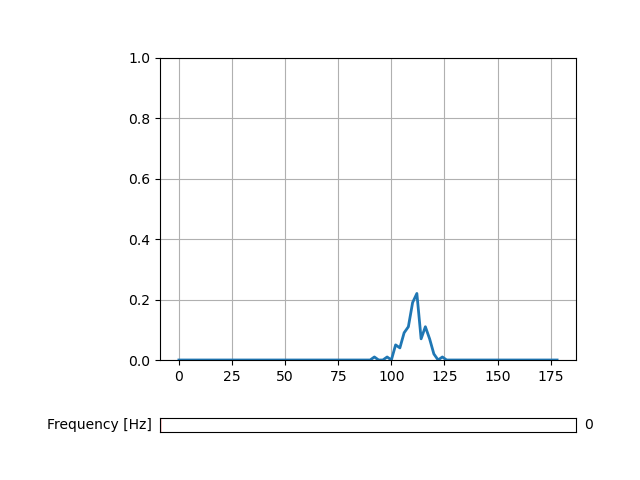

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


#def f(t, frequency):
    #return 4 * np.sin(2 * np.pi * frequency * t)

def f(t,array):
    return array[t]

def update(val):
    line.set_ydata(f(int(freq_slider.val), P_even))
    fig.canvas.draw_idle()

    
t = 0

#init_frequency = 250

fig, ax = plt.subplots()
line, = plt.plot([i*2 for i in range(len(P_even[t]))], f(t, P_even), lw=2)

ax.set_ylim(0,1)
plt.grid()

axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])


freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0,
    valmax=500,
    valfmt = "%d",
    valinit=t,
)

plt.subplots_adjust(left=0.25, bottom=0.25)

freq_slider.on_changed(update)
plt.show()